In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 92% 137M/149M [00:00<00:00, 177MB/s]
100% 149M/149M [00:00<00:00, 189MB/s]


In [ ]:
!unzip -qq brain-tumor-mri-dataset.zip 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline
     

In [ ]:
tf.keras.utils.set_random_seed(1234)

In [ ]:
imagePaths = "Training"
test_path="Testing"

In [ ]:
!ls -al Testing

total 64
drwxr-xr-x 6 root root  4096 Jan 30 16:32 .
drwxr-xr-x 1 root root  4096 Jan 30 16:32 ..
drwxr-xr-x 2 root root 12288 Jan 30 16:32 glioma
drwxr-xr-x 2 root root 12288 Jan 30 16:32 meningioma
drwxr-xr-x 2 root root 20480 Jan 30 16:32 notumor
drwxr-xr-x 2 root root 12288 Jan 30 16:32 pituitary


In [ ]:
batch_size=16
img_height = 512
img_width = 512

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 856 files for validation.


In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  #seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 1311 files belonging to 4 classes.


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(16, 512, 512, 3)
(16,)


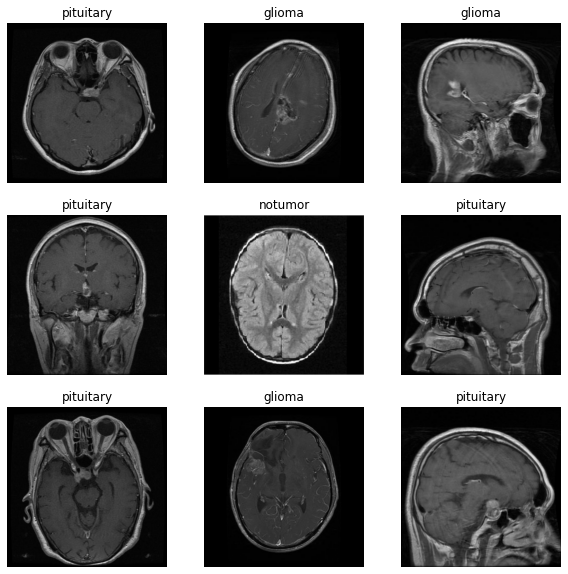

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation= Sequential([
                               layers.RandomFlip("horizontal"),
                               layers.RandomBrightness(factor=0.1, value_range=(0, 255), seed=123)
])

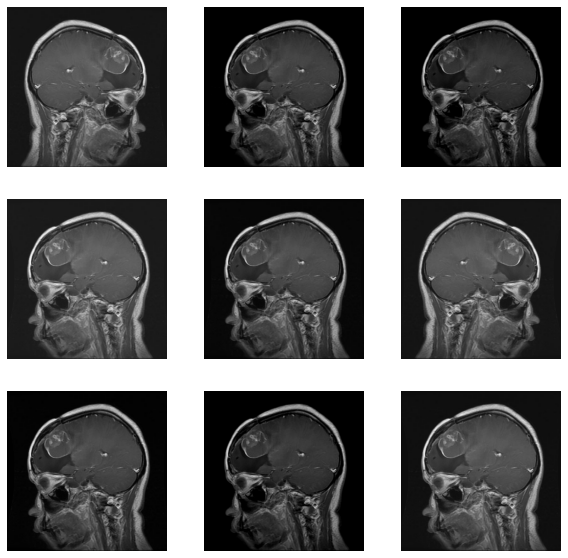

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
inputs= keras.Input(shape=(img_height, img_width,3))
#x = data_augmentation(inputs)
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
        
#Block: 1
x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(128, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(64, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


#Block: 2
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = Conv2D(16, kernel_size=(3, 3), activation='relu',padding='SAME')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.3)(x)


x = Flatten(name='flatten')(x)
x = Dense(units=8, activation='relu')(x)
outputs = Dense(units=4, activation='softmax')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 512, 512, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 512, 512, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 128)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 256, 256, 128)     0         
                                                             

In [143]:
from keras.utils.vis_utils import plot_model

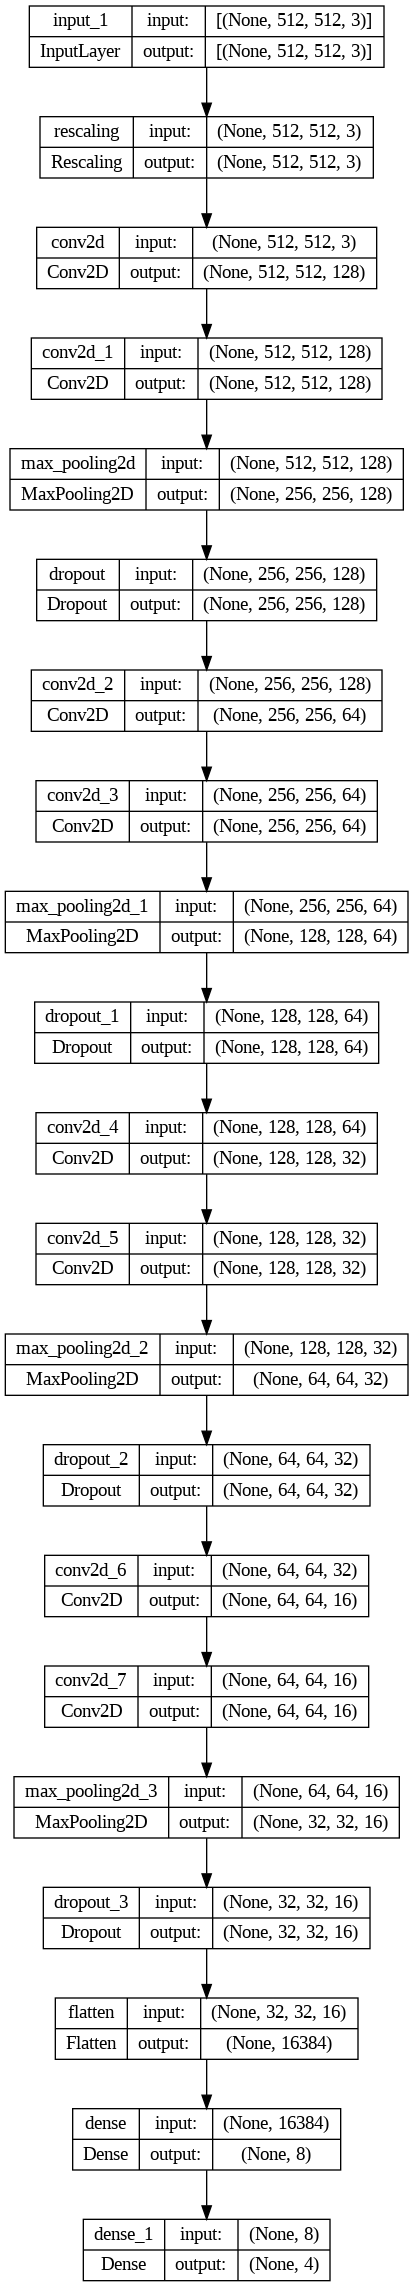

In [144]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [ ]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [ ]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [ ]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [ ]:
class_weights = generate_class_weights(y_train.numpy())

In [ ]:
class_weights

{0: 1.0639789658194567,
 1: 1.0848972296693475,
 2: 0.8992592592592593,
 3: 0.9743178170144462}

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, class_weight=class_weights, callbacks=callbacks)

Epoch 1/50
304/304 [==============================] - ETA: 0s - loss: 0.5134 - accuracy: 0.8200
Epoch 1: val_accuracy improved from -inf to 0.79439, saving model to checkpoints_best_only


304/304 [==============================] - 365s 1s/step - loss: 0.5134 - accuracy: 0.8200 - val_loss: 0.4872 - val_accuracy: 0.7944
Epoch 2/50
304/304 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8645
Epoch 2: val_accuracy improved from 0.79439 to 0.81192, saving model to checkpoints_best_only


304/304 [==============================] - 363s 1s/step - loss: 0.3992 - accuracy: 0.8645 - val_loss: 0.4529 - val_accuracy: 0.8119
Epoch 3/50
304/304 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.8900
Epoch 3: val_accuracy improved from 0.81192 to 0.87617, saving model to checkpoints_best_only


304/304 [==============================] - 362s 1s/step - loss: 0.3172 - accuracy: 0.8900 - val_loss: 0.3348 - val_accuracy: 0.8762
Epoch 4/50
304/304 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.9077
Epoch 4: val_accuracy did not improve from 0.87617
304/304 [==============================] - 360s 1s/step - loss: 0.2577 - accuracy: 0.9077 - val_loss: 0.3441 - val_accuracy: 0.8692
Epoch 5/50
304/304 [==============================] - ETA: 0s - loss: 0.2186 - accuracy: 0.9226
Epoch 5: val_accuracy improved from 0.87617 to 0.88551, saving model to checkpoints_best_only


304/304 [==============================] - 361s 1s/step - loss: 0.2186 - accuracy: 0.9226 - val_loss: 0.3068 - val_accuracy: 0.8855
Epoch 6/50
304/304 [==============================] - ETA: 0s - loss: 0.1646 - accuracy: 0.9430
Epoch 6: val_accuracy improved from 0.88551 to 0.89136, saving model to checkpoints_best_only


304/304 [==============================] - 360s 1s/step - loss: 0.1646 - accuracy: 0.9430 - val_loss: 0.3500 - val_accuracy: 0.8914
Epoch 7/50
304/304 [==============================] - ETA: 0s - loss: 0.1413 - accuracy: 0.9463
Epoch 7: val_accuracy improved from 0.89136 to 0.91005, saving model to checkpoints_best_only


304/304 [==============================] - 360s 1s/step - loss: 0.1413 - accuracy: 0.9463 - val_loss: 0.2681 - val_accuracy: 0.9100
Epoch 8/50
304/304 [==============================] - ETA: 0s - loss: 0.1356 - accuracy: 0.9549
Epoch 8: val_accuracy did not improve from 0.91005
304/304 [==============================] - 358s 1s/step - loss: 0.1356 - accuracy: 0.9549 - val_loss: 0.2953 - val_accuracy: 0.9077
Epoch 9/50
304/304 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9561
Epoch 9: val_accuracy did not improve from 0.91005
304/304 [==============================] - 359s 1s/step - loss: 0.1292 - accuracy: 0.9561 - val_loss: 0.3394 - val_accuracy: 0.9077
Epoch 10/50
304/304 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9683
Epoch 10: val_accuracy improved from 0.91005 to 0.91472, saving model to checkpoints_best_only


304/304 [==============================] - 359s 1s/step - loss: 0.0928 - accuracy: 0.9683 - val_loss: 0.3627 - val_accuracy: 0.9147
Epoch 11/50
304/304 [==============================] - ETA: 0s - loss: 0.0900 - accuracy: 0.9699
Epoch 11: val_accuracy did not improve from 0.91472
304/304 [==============================] - 357s 1s/step - loss: 0.0900 - accuracy: 0.9699 - val_loss: 0.4217 - val_accuracy: 0.8960
Epoch 12/50
304/304 [==============================] - ETA: 0s - loss: 0.0642 - accuracy: 0.9784
Epoch 12: val_accuracy improved from 0.91472 to 0.92056, saving model to checkpoints_best_only


304/304 [==============================] - 359s 1s/step - loss: 0.0642 - accuracy: 0.9784 - val_loss: 0.3733 - val_accuracy: 0.9206


In [ ]:
model.evaluate(test_ds)

82/82 [==============================] - 45s 542ms/step - loss: 0.2853 - accuracy: 0.9260


[0.28530043363571167, 0.9260106682777405]

In [ ]:
import matplotlib.pyplot as plt

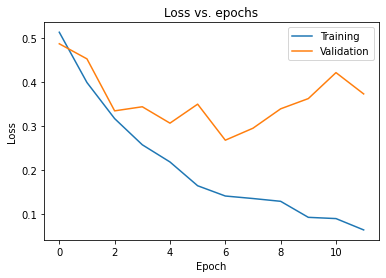

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

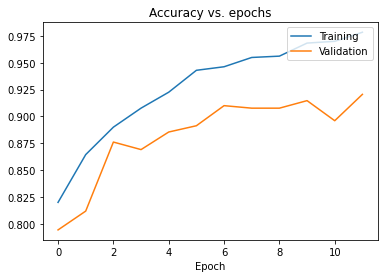

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 41ms/step


In [ ]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[277  22   0   1]
 [ 34 247  11  14]
 [  2   4 399   0]
 [  2   7   0 291]]


In [ ]:
classes=['glioma','meningioma', 'notumor','pituitary']

[[277  22   0   1]
 [ 34 247  11  14]
 [  2   4 399   0]
 [  2   7   0 291]]


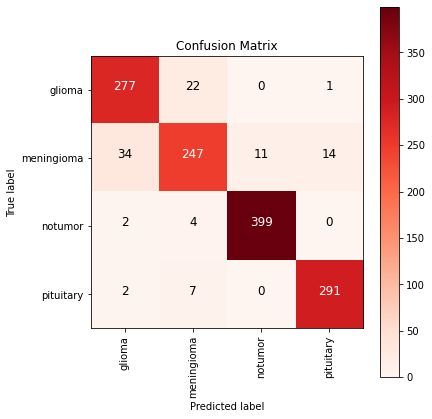

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [ ]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.88      0.92      0.90       300
  meningioma       0.88      0.81      0.84       306
     notumor       0.97      0.99      0.98       405
   pituitary       0.95      0.97      0.96       300

    accuracy                           0.93      1311
   macro avg       0.92      0.92      0.92      1311
weighted avg       0.93      0.93      0.93      1311



In [ ]:
model.save("brain_model.h5")

In [ ]:
for i in model.layers:
  print(i.name)

input_1
rescaling
conv2d
conv2d_1
max_pooling2d
dropout
conv2d_2
conv2d_3
max_pooling2d_1
dropout_1
conv2d_4
conv2d_5
max_pooling2d_2
dropout_2
conv2d_6
conv2d_7
max_pooling2d_3
dropout_3
flatten
dense
dense_1


In [ ]:
from IPython.display import Image, display
     

def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
img_path = tf.keras.utils.get_file(
    "tumor.jpg", 
    "https://scx2.b-cdn.net/gfx/news/hires/2009/acrystalball.jpg"
)
    

In [ ]:
def get_img_array(img_path, target_size):
  img = keras.utils.load_img(img_path, target_size=target_size)
  array = keras.utils.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  return array

In [ ]:
img_array = get_img_array(img_path, target_size=(512, 512))

In [ ]:
last_conv_layer_name = "conv2d_7"
# Remove last layer's softmax
model.layers[-1].activation = None

1/1 [==============================] - 0s 21ms/step
Predicted: [7.2832221e-17 2.2774352e-06 9.9999774e-01 2.9745153e-09]


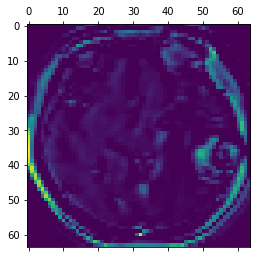

In [ ]:
# Print what the top predicted class is
preds = model.predict(img_array)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
import matplotlib.cm as matcm

In [ ]:
from IPython.display import Image, display
     

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = matcm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
     

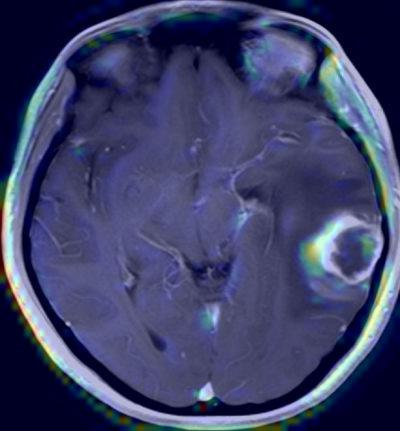

In [ ]:
save_and_display_gradcam(img_path, heatmap)

In [ ]:
img_path1 = tf.keras.utils.get_file(
    "tumor6.jpg", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/2.jpeg"
)

In [ ]:
img_array1 = get_img_array(img_path1, target_size=(512, 512))

1/1 [==============================] - 0s 20ms/step
Predicted: [1.3241778e-06 9.9999213e-01 6.4272185e-06 1.2379220e-07]


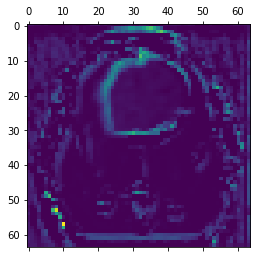

In [ ]:
# Print what the top predicted class is
preds = model.predict(img_array1)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array1, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

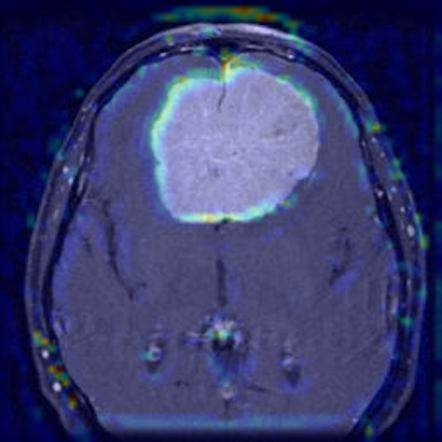

In [ ]:
save_and_display_gradcam(img_path1, heatmap)

In [ ]:
img_path2 = tf.keras.utils.get_file(
    "tumor9.jpg", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/4.jpeg"
)

In [ ]:
img_array2 = get_img_array(img_path2, target_size=(512, 512))

1/1 [==============================] - 0s 23ms/step
Predicted: [8.9292653e-09 1.0000000e+00 9.7001713e-09 3.0030552e-08]


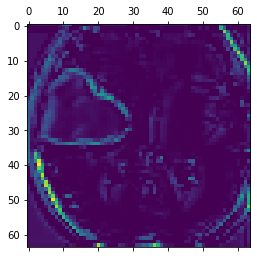

In [ ]:
# Print what the top predicted class is
preds = model.predict(img_array2)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array2, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

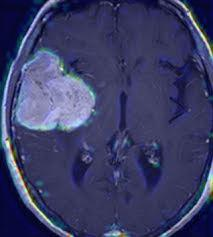

In [ ]:
save_and_display_gradcam(img_path2, heatmap)

In [138]:
img_path4 = tf.keras.utils.get_file(
    "glioma3.jpg", 
    "https://raw.githubusercontent.com/ayyucedemirbas/dummy_ds_to_delete/main/7.jpg"
)

106377/106377 [==============================] - 0s 0us/step


In [139]:
img_array4 = get_img_array(img_path4, target_size=(512, 512))

1/1 [==============================] - 0s 20ms/step
Predicted: [4.9134204e-34 9.0455492e-18 1.0000000e+00 7.7333047e-22]


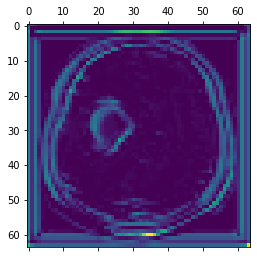

In [140]:
# Print what the top predicted class is
preds = model.predict(img_array4)
print("Predicted:", preds[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array4, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

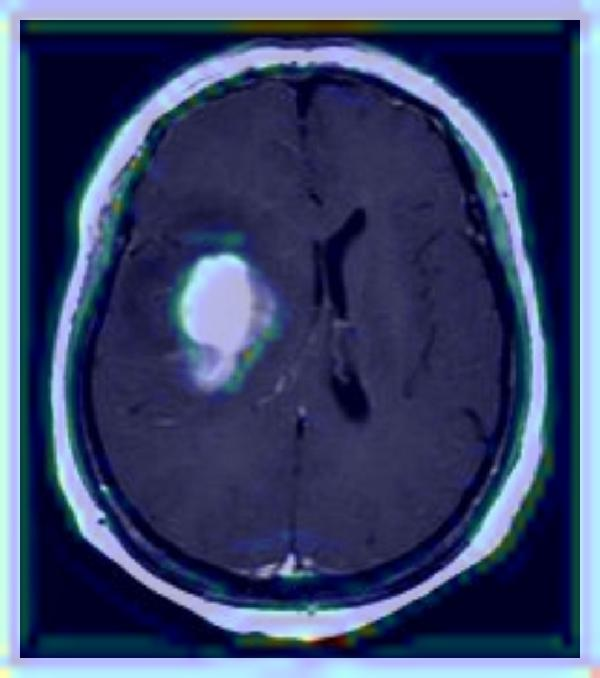

In [141]:
save_and_display_gradcam(img_path4, heatmap)